In [504]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import os
from datetime import datetime

import torch
from torchvision import datasets


from torch.utils.tensorboard import SummaryWriter
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

In [505]:
# Defining future parameters
# check device
DEVICE = 'cuda'if torch.cuda.is_available() else 'cpu'
# parameters
RANDOM_SEED = 42
LEARNING_RATE = 0.001
BATCH_SIZE = 32
N_EPOCHS = 15
IMG_SIZE = 28
N_CLASSES = 100
PATIENCE = 5  # Found after several trials

writer = SummaryWriter()  # This Summary Writer will help me to show results on Tensorboard later

In [506]:
# Function to create a 2-digit MNIST image
def create_two_digit_image(digit1, digit2, mnist_data):
    # Get random images for the given digits. This uses the random integer to index the tensor containing all images labeled as digit1.
    # As a result, it randomly selects one image from the set of images labeled as digit1
    img1 = mnist_data.data[mnist_data.targets == digit1][torch.randint(0, (mnist_data.targets == digit1).sum(), (1,))]
    img2 = mnist_data.data[mnist_data.targets == digit2][torch.randint(0, (mnist_data.targets == digit2).sum(), (1,))]
    
    # Create a blank canvas to place the two images side by side
    new_image = torch.zeros((28, 56), dtype=torch.uint8)
    new_image[:, :28] = img1
    new_image[:, 28:] = img2
    
    return new_image

def create_one_digit_image_below_ten(digit2, mnist_data):
    img2 = mnist_data.data[mnist_data.targets == digit2][torch.randint(0, (mnist_data.targets == digit2).sum(), (1,))]
    new_image_below_ten = torch.zeros((28, 56), dtype=torch.uint8)
    new_image_below_ten[:, 28:] = img2

    return new_image_below_ten

In [507]:
# Custom Dataset class in order to deal with my new images and labels
class TwoDigitMNISTDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx].float() / 255.0  # Convert to float and normalize
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
            
        image = image.unsqueeze(0) ## Add channel dimension: [1, 28, 56]
        
        return image, label

In [508]:
# Checking the shape
two_digit_images.shape

torch.Size([60000, 28, 56])

In [509]:
# In case I want to plot here, for now used TensorBoard    
def plot_losses (train_losses,valid_losses): 
    
    plt.style.use('seaborn')
    train_losses = np.array(train_losses)
    valid_losses = np.array(valid_losses)
    fig, ax = plt.subplots(figsize=(8,4.5))
    ax.plot(train_losses,color='blue',label='Training loss')
    ax.plot(valid_losses,color='red',label='Validation loss')
    ax.set( title="Loss over epochs",
            xlabel='Epoch',
            ylabel='Loss')
    ax.legend()
    
    plt.style.use('default')
    plt.show()

In [510]:
# We now define the training part
def train(train_loader, model, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct_pred = 0
    n = 0
    for X, y_true in train_loader:
        X = X.to(device)
        y_true = y_true.to(device)
        
        # Forward pass
        y_hat = model(X)
        
        # Compute loss
        loss = criterion(y_hat, y_true)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * X.size(0)

        # Calculate accuracy
        _, predicted_labels = torch.max(y_hat, 1)
        correct_pred += (predicted_labels == y_true).sum().item()
        n += y_true.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = correct_pred / n
    return model, optimizer, epoch_loss, epoch_acc


In [511]:
def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, patience):
    train_losses = []
    valid_losses = []
    train_accuracies = []
    valid_accuracies = []

    best_valid_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(epochs):
        model, optimizer, train_loss, train_acc = train(train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        
        model.eval()
        running_loss = 0.0
        correct_pred = 0
        n = 0
        with torch.no_grad():
            for X, y_true in valid_loader:
                X = X.to(device)
                y_true = y_true.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y_true)
                running_loss += loss.item() * X.size(0)
                # Calculate accuracy
                _, predicted_labels = torch.max(y_hat, 1)
                correct_pred += (predicted_labels == y_true).sum().item()
                n += y_true.size(0)
        
        valid_loss = running_loss / len(valid_loader.dataset)
        valid_losses.append(valid_loss)
        valid_acc = correct_pred / n
        valid_accuracies.append(valid_acc)
        writer.add_scalar("Loss/train", loss, epoch)

        
        print(f"Epoch {epoch+1}/{epochs}.. Train loss: {train_loss:.3f}.. Validation loss: {valid_loss:.3f}.. Train accuracy:{100*train_acc:.3f}.. Valid accuracy: {100*valid_acc:.3f} ")
        
         # Check for early stopping
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs")
                break
    writer.flush()

    return model, optimizer, (train_losses, valid_losses, train_accuracies, valid_accuracies)

In [512]:
# Let's define our net  
class LeNet5(nn.Module):

    def __init__(self,n_classes):
        super(LeNet5,self).__init__()
        self.feature_extractor = nn.Sequential(
        nn.Conv2d(in_channels=1,out_channels=6,kernel_size=5,stride=1,padding=2),#28x56
        #nn.Conv2d(in_channels=1,out_channels=6,kernel_size=5,stride=1),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2, stride=2),#16x28 #prima dello stride
        nn.Conv2d(in_channels=6,out_channels=16,kernel_size=5,stride=1),#12x24
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2, stride=2),#6x12
        #nn.Conv2d(in_channels=16,out_channels=120,kernel_size=5,stride=1),
        #nn.Tanh()
        )
        self.classifier = nn.Sequential(
        nn.Linear(in_features=16*5*12, out_features=120),
        nn.Tanh(),
        nn.Linear(in_features=120,out_features=84),
        nn.Tanh(),
        nn.Linear(in_features=84,out_features=N_CLASSES),)
    def forward(self,x):
        x = self.feature_extractor(x)
        x = torch.flatten(x,1)
        logits = self.classifier(x)
        return logits


Qui dovresti richiamare il tutto come fa nel main alla slide 41

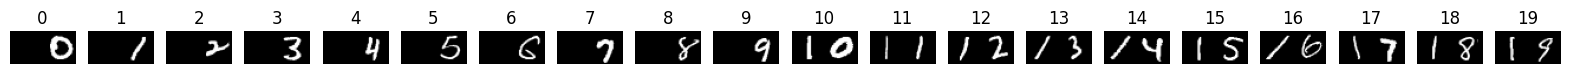

In [513]:
# Load MNIST dataset
transform=transforms.Compose([transforms.Resize((IMG_SIZE,IMG_SIZE)),transforms.ToTensor()])  
mnist_train = datasets.MNIST(root='.', train=True, download=True, transform=transform)
mnist_val = datasets.MNIST(root='.', train=False, download=True, transform=transform)


# Example: Create images for two-digit numbers, for training set.
two_digit_images = []
two_digit_labels = []


for k in range (0, 600):  # In order to have the same amount of images as the original dataset (60k for training set)
    for i in range(0, 10):
        for j in range(10):
            if i == 0 and j < 10:
                new_image_below_ten = create_one_digit_image_below_ten(j, mnist_train)
                two_digit_images.append(new_image_below_ten)
                two_digit_labels.append(j)
                continue
            new_image = create_two_digit_image(i, j, mnist_train)
            two_digit_images.append(new_image)
            two_digit_labels.append(i * 10 + j)

# Convert to tensor
two_digit_images = torch.stack(two_digit_images)
two_digit_labels = torch.tensor(two_digit_labels)


# Same for validation set

two_digit_images_val = []
two_digit_labels_val = []


for k in range (0,100):  # 10k for the testing set as the original dataset
    for i in range(0, 10):
        for j in range(10):
            if i == 0 and j < 10:
                new_image_below_ten = create_one_digit_image_below_ten(j, mnist_val)
                two_digit_images_val.append(new_image_below_ten)
                two_digit_labels_val.append(j)
                continue
            new_image = create_two_digit_image(i, j, mnist_val)
            two_digit_images_val.append(new_image)
            two_digit_labels_val.append(i * 10 + j)

# Convert to tensor
two_digit_images_val = torch.stack(two_digit_images_val)
two_digit_labels_val = torch.tensor(two_digit_labels_val)



# Display some examples
fig, axes = plt.subplots(1, 20, figsize=(20, 2))
for i in range(0, 20):
    axes[i].imshow(two_digit_images_val[i], cmap='gray')
    axes[i].set_title(f"{two_digit_labels_val[i]}")
    axes[i].axis('off')
plt.show()


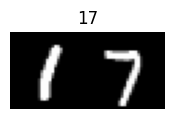

In [514]:
# Following part is to show that every couple of numbers is a randomic combination of two of the original dataset
fig, axes = plt.subplots(1, 1, figsize=(2, 2))
axes.imshow(two_digit_images_val[117], cmap='gray')
axes.set_title(f"{two_digit_labels_val[117]}")
axes.axis('off')
plt.show()


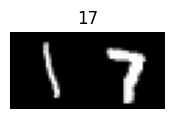

In [515]:
fig, axes = plt.subplots(1, 1, figsize=(2, 2))
axes.imshow(two_digit_images_val[17], cmap='gray')
axes.set_title(f"{two_digit_labels_val[17]}")
axes.axis('off')
plt.show()


In [516]:
# Let's create our custom dataset           

two_digit_dataset = TwoDigitMNISTDataset(two_digit_images, two_digit_labels)
two_digit_dataset_val = TwoDigitMNISTDataset(two_digit_images_val, two_digit_labels_val)

#define the data loaders
train_loader = DataLoader(  dataset=two_digit_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=True)
valid_loader = DataLoader(  dataset=two_digit_dataset_val,
                            batch_size=BATCH_SIZE,
                            shuffle=False)




Epoch 1/15.. Train loss: 0.916.. Validation loss: 0.264.. Train accuracy:79.208.. Valid accuracy: 92.960 
Epoch 2/15.. Train loss: 0.200.. Validation loss: 0.161.. Train accuracy:94.540.. Valid accuracy: 95.260 
Epoch 3/15.. Train loss: 0.130.. Validation loss: 0.144.. Train accuracy:96.290.. Valid accuracy: 95.530 
Epoch 4/15.. Train loss: 0.099.. Validation loss: 0.119.. Train accuracy:97.110.. Valid accuracy: 96.410 
Epoch 5/15.. Train loss: 0.079.. Validation loss: 0.120.. Train accuracy:97.677.. Valid accuracy: 96.350 
Epoch 6/15.. Train loss: 0.063.. Validation loss: 0.132.. Train accuracy:98.088.. Valid accuracy: 96.270 
Epoch 7/15.. Train loss: 0.053.. Validation loss: 0.129.. Train accuracy:98.403.. Valid accuracy: 96.150 
Epoch 8/15.. Train loss: 0.048.. Validation loss: 0.114.. Train accuracy:98.508.. Valid accuracy: 96.880 
Epoch 9/15.. Train loss: 0.040.. Validation loss: 0.123.. Train accuracy:98.753.. Valid accuracy: 96.480 
Epoch 10/15.. Train loss: 0.038.. Validation l

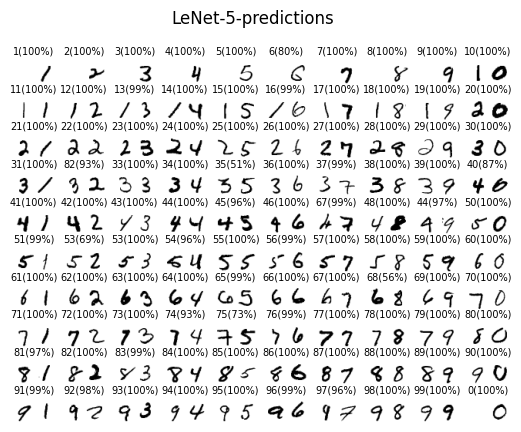

In [517]:
torch.manual_seed(RANDOM_SEED)
model=LeNet5(N_CLASSES).to(DEVICE)
optimizer=torch.optim.Adam(model.parameters(),lr=LEARNING_RATE)
criterion=nn.CrossEntropyLoss()
model,optimizer,(train_losses, valid_losses, train_accuracies, valid_accuracies)=training_loop(model,criterion,optimizer,train_loader,valid_loader,N_EPOCHS,DEVICE,PATIENCE)
# drawing some results
ROW_IMG=10
N_ROWS=10
fig=plt.figure()
for index in range(1,ROW_IMG*N_ROWS+1):
    plt.subplot(N_ROWS,ROW_IMG,index)
    plt.axis('off')
    image, label = two_digit_dataset_val[index]
    plt.imshow(image.squeeze(),cmap='gray_r')
    with torch.no_grad():
        model.eval()
        X=image.unsqueeze(0).to(DEVICE)
        logits=model(X)
        probs = torch.softmax(logits, dim=1)
        title=f'{torch.argmax(probs).item()}({torch.max(probs).item()*100:.0f}%)'
        plt.title(title,fontsize=7)
fig.suptitle('LeNet-5-predictions')
plt.show()
writer.flush()